In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import scipy
plt.rcParams.update({'font.size': 14})

plt.close('all')
from matplotlib import rcParams, cycler

from helpers import *

## Input Data

In [3]:
INPUT_POP_PATH = "inputs/population_CH.csv"
pop_spline = interpolation2D(INPUT_POP_PATH, 3, 3)

In [5]:
# Parameters of the model

location = 'Switzerland'
ti = 1950
tf = 2020

h = 1. # length time interval

A = 100
t0 = 1950
T = tf-t0

M = int(A/h) # M+1 = number of data points
N = int(T/h)

In [6]:
# Function p(a,t) : population
def p(x, t):
    return pop_spline(x,t0+t)

# Function beta(a,t) : age specific fertility
def beta(x,t):
    TFR = 0 # TFR in 1950, first keep it cst
    ret = np.heaviside(x-15, 1) - np.heaviside(x-45, 1)
    return ret*TFR/(2*30)

# Function mu(a,t) : age specific mortality
def mu(x,t):
    ret = 0.0
    return ret

# Function pi(a,t) : survival probability
def pi(x, t):
    Isum = 0
    M = 50
    d = x/(M-1)
    for i in range(0,M):
        Isum += (mu(i*d, t)+mu((i+1)*d, t))/2
    ret = np.exp(- d*Isum)
    return ret

# Function alpha for the resolution of the total population
def alpha(n):
    Asum = 0
    for i in range(1,M):
        Asum += (beta(a[i], t[n]) - mu(a[i], t[n]))*V[i,n]
    An = (h/2.)*( (beta(a[0],t[n]) - mu(a[0],t[n]))*V[0,n] + 2*sum_A + (beta(a[M],t[n]) - mu(a[M],t[n]))*V[M,n])
    return An

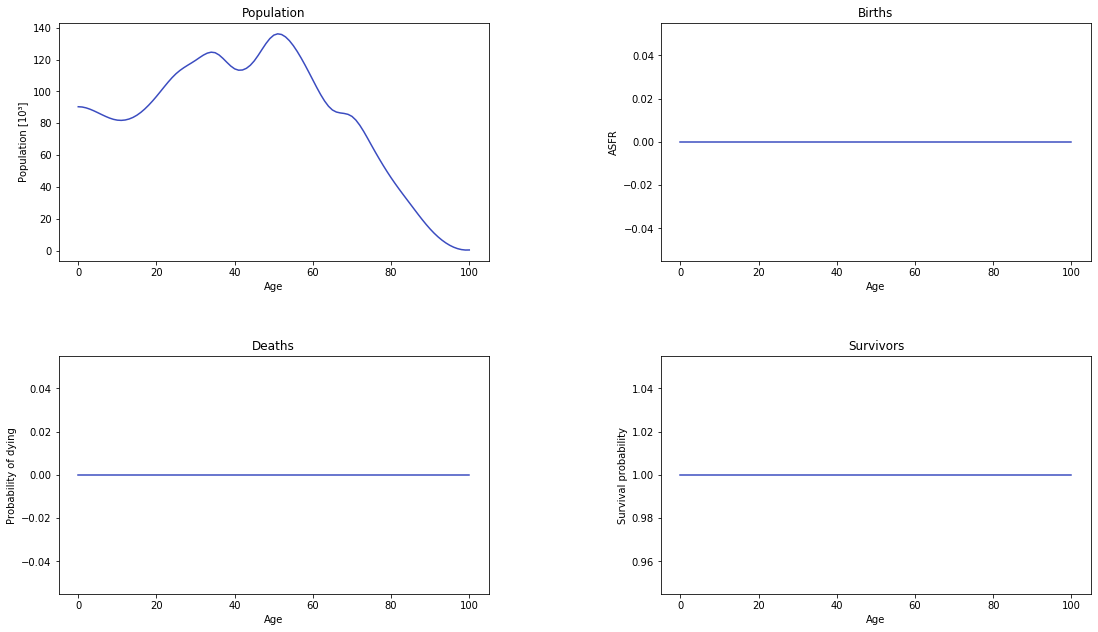

In [16]:
a = np.linspace(0,A,M+1)
t = np.linspace(0,T,N+1)
time_ind = 100

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(18.5, 10.5)

ax = fig.add_subplot(2, 2, 1)
ax.set(title='Population', xlabel='Age', ylabel='Population [10³]')
ax.plot(a, p(a, time_ind))

ax = fig.add_subplot(2, 2, 2)
ax.set(title='Births', xlabel='Age', ylabel='ASFR')
ax.plot(a, beta(a, time_ind))

m_v = np.zeros((M+1,1))
for j in range(0,M+1):
    m_v[j] = mu(a[j], time_ind)
ax = fig.add_subplot(2, 2, 3)
ax.set(title='Deaths', xlabel='Age', ylabel='Probability of dying')
ax.plot(a, m_v)

pi_v = np.zeros((M+1,1))
for j in range(0,M+1):
    pi_v[j] = pi(a[j], time_ind)
ax = fig.add_subplot(2, 2, 4)
ax.set(title='Survivors', xlabel='Age', ylabel='Survival probability')
ax.plot(a, pi_v)

## Case 1 : Switzerland, start in 1950

In [7]:
# Discretization of time and age
t = np.linspace(0,T,N+1)
a = np.linspace(0,A,M+1)

V = np.zeros((M+1,N+1))
TotalPop = np.zeros((N+1,1))
P = np.zeros((M+1,N+1))

A_ = np.zeros((M+1,N+1))
A_half = np.zeros((M+1,N+1))

# Initial condition
v0 = np.asarray(p(a, 0)).ravel()
V[:,0] = v0/np.sum(v0) # initial population repartition

/home/louise/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


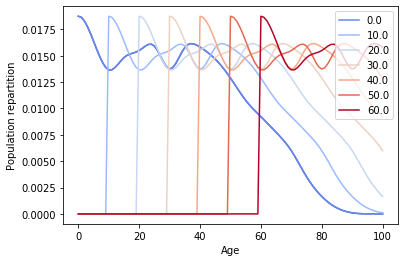

In [15]:
TotalPop[0] = np.sum(v0)
alpha_v = np.zeros((N+1,1))

for n in range(0,N+1):
    alpha_v[n] = alpha(n)

plt.figure()

cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N/10+1)))
plt.plot(a, V[:,0])

alpha_v[0] = alpha(0)

for n in range (0,N): # loop on time
    TotalPop[n+1] = (1 + h*alpha_v[n])*TotalPop[n]
    
    # coefficient of A
    sum_A = 0
    for i in range (1,M):
        sum_A += (beta(a[i],t[n]) - mu(a[i],t[n]))*V[i,n]
    An = (h/2.)*( (beta(a[0],t[n]) - mu(a[0],t[n]))*V[0,n] + 2*sum_A + (beta(a[M],t[n]) - mu(a[M],t[n]))*V[M,n])
    
    for i in range (1,M):
        A_[i,n] = mu(a[i],t[n]) + An
    
    sum_Ah = 0
    for i in range (0,M):
        sum_Ah += (beta(a[i],t[n]+h/2.) - mu(a[i],t[n]+h/2.))*V[i,n]
    Ahn = (h/2.)*( (beta(a[0],t[n]+h/2.) - mu(a[0],t[n]+h/2.))*V[0,n] + 2*sum_A + (beta(a[M],t[n]+h/2.) - mu(a[M],t[n]+h/2.))*V[M,n])
        
    for i in range (0,M):
        A_half[i, n] = mu(a[i]+h/2.,t[n]+h/2.) + h*sum_Ah*(1-h*A_[i,n])
    
    for i in range (0,M): # loop on age
        K1 = - h*A_half[i,n]*V[i,n]
        K2 = - (h/2.)*A_[i,n]*K1
        V[i+1,n+1] = V[i,n] + K2 + K1
        
        
    # Boundary condition
    sum_init = 0
    for i in range(1,M):
        sum_init += 2*beta(a[i], t[n])*V[i,n]
    sum_init += beta(a[M], t[n])*V[M,n]
    V[0,n+1] = (h/(2-h*beta(a[0],t[n])))*sum_init
    
    V[:,n+1] = V[:,n+1]*TotalPop[n]/TotalPop[n+1] # renormalization wrt to new total pop
        
    if(0 == np.mod(n,10)):
        plt.plot(a, V[:,n], label=t[n])    
        
plt.xlabel('Age')
plt.ylabel('Population repartition')
plt.legend(loc ='upper right')

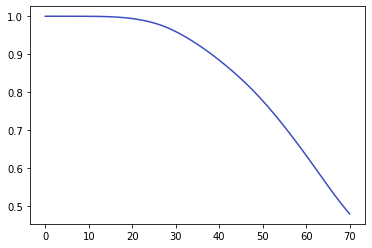

In [10]:
# Verification 
sumV = np.zeros((N+1,1))

for n in range (0,N+1):
    sumV[n] = np.sum(V[:,n])
    
fig = plt.figure()

plt.plot(t, sumV)

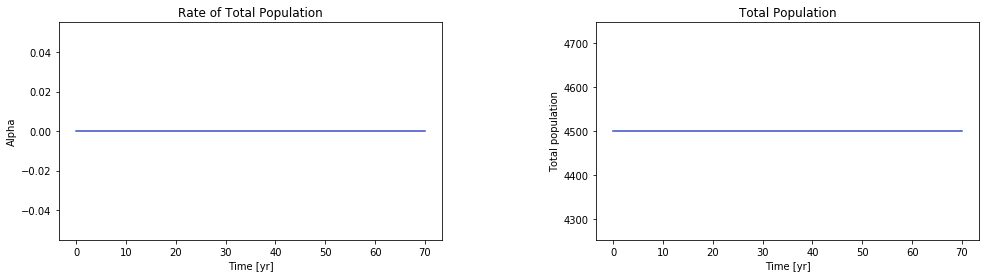

In [11]:
# Resolution of equation on P
TotalPop[0] = np.sum(v0)
alpha_v = np.zeros((N+1,1))

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(16.5, 4)

for n in range(0,N+1):
    alpha_v[n] = alpha(n)
ax = fig.add_subplot(1, 2, 1)
ax.set(title='Rate of Total Population', xlabel='Time [yr]', ylabel='Alpha')
ax.plot(t, alpha_v)


for n in range(0,N):
    TotalPop[n+1] = (1 + h*alpha_v[n])*TotalPop[n]
ax = fig.add_subplot(1, 2, 2)
ax.set(title='Total Population', xlabel='Time [yr]', ylabel='Total population')
ax.plot(t, TotalPop)

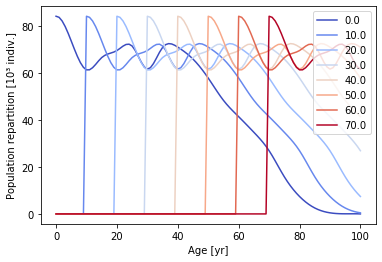

In [13]:
fig = plt.figure()

for n in range(0,N+1):
    P[:,n] = V[:,n]*TotalPop[n]
    if(0 == np.mod(n,10)):
        plt.plot(a, P[:,n], label=t[n])
        
plt.xlabel('Age [yr]')
plt.ylabel('Population repartition [10³ indiv.]')
plt.legend(loc ='upper right')

In [14]:
fig.savefig('outputs/population_RK2.png', dpi=100, bbox_inches = "tight")